In [1]:
import spacy
from spacy.matcher import Matcher
from zipfile import ZipFile
from pathlib import Path
from tqdm import autonotebook as tqdm
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
path = Path(os.getcwd()).parent

with Path(os.path.join(path, "data/teaching-dataset/sentence_classification_text_train.zip")).open("rb") as file:
    zip_file = ZipFile(file)
    with zip_file.open("input.txt") as f:
        sentences = f.read().decode("utf-8").splitlines()

with Path(os.path.join(path, "data/teaching-dataset/sentence_classification_text_train.zip")).open("rb") as file:
    zip_file = ZipFile(file)
    with zip_file.open("references.txt") as f:
        labels = f.read().decode("utf-8").splitlines()

In [4]:
train_sentences, test_sentences, train_labels, test_labels =  train_test_split(sentences, labels, test_size=0.2, random_state=42)

In [46]:
#count most common words in sentences that have causal relationship
from collections import Counter
from collections.abc import Iterable

# from: https://stackoverflow.com/questions/17485747/how-to-convert-a-nested-list-into-a-one-dimensional-list-in-python
def flatten(lis): #pretty ugly solution but we have to flatten the list since every new sentence adds "[]" which Counter can't deal with
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item

words = []
nonCausalWords = []

for label, sentence in zip(train_labels, train_sentences):
    if label == "1": #if sentence is causal
        doc = nlp(sentence)
        wordsHelp = [token.text for token in doc if not token.is_stop and not token.is_punct and token.pos_ != "NOUN" and token.pos_ != "ADJ"] 
        words.append(wordsHelp) #append all words to a list if they are NOT nouns & NOT punctuation & NOT adjectives

    if label == "0": #if sentence is NOT causal
        doc = nlp(sentence)
        wordsHelp = [token.text for token in doc if not token.is_stop and not token.is_punct and token.pos_ != "NOUN" and token.pos_ != "ADJ"] 
        nonCausalWords.append(wordsHelp)


In [36]:
nonCausal_freq = Counter(flatten(nonCausalWords))
print(nonCausal_freq.most_common(20))

[('inside', 42), ('placed', 21), ('found', 18), ('away', 15), ('like', 14), ('came', 12), ('poured', 12), ('moved', 12), ('million', 12), ('took', 11), ('created', 11), ('arrived', 10), ('usually', 10), ('sent', 10), ('known', 9), ('$', 9), ('near', 9), ('left', 9), ('published', 9), ('derived', 9)]


In [103]:
def get_n_lemmata(causal_freq, n):
    # sort words
    sorted_words = np.array(causal_freq.most_common(len(causal_freq)))[:,0]
    converted_return = []
    for word in sorted_words:
        # lemmatize
        doc = nlp(str(word))
        word = " ".join([token.lemma_ for token in doc])
        if not word in converted_return:
            converted_return.append(word)
        # break if n lemmata found
        if len(converted_return)==n:
            break
    return converted_return

def get_n_best_words_by_relative_difference(n):
    causal_freq = Counter(flatten(words))
    nonCausal_freq = Counter(flatten(nonCausalWords))
    for word in causal_freq:
        causal_freq[word] = causal_freq[word]/(nonCausal_freq[word]+1)
    common_words = get_n_lemmata(causal_freq,n)
    return common_words

def get_n_best_words_by_absolute_difference(n):
    causal_freq = Counter(flatten(words))
    nonCausal_freq = Counter(flatten(nonCausalWords))
    for word in causal_freq:
        causal_freq[word] = causal_freq[word]-(nonCausal_freq[word]+1)
    common_words = get_n_lemmata(causal_freq,n)
    return common_words

def get_n_best_words_by_occurence(n):
    causal_freq = Counter(flatten(words))
    common_words = get_n_lemmata(causal_freq,n)
    return common_words

print(f"Top 40 by relative difference: {get_n_best_words_by_relative_difference(40)}")
print(f"Top 40 by absolute difference: {get_n_best_words_by_absolute_difference(40)}")
print(f"Top 40 by occurence in causal sentences: {get_n_best_words_by_occurence(40)}")

Top 40 by relative difference: ['cause', 'result', 'lead', 'occur', 'trigger', 'include', 'associate', 'Haiti', 'particularly', 'agep', 'eat', 'hht', 'generate', 'swell', 'show', 'lobe', 'reduce', 'HLA', 'induce', 'locate', 'approximately', 'increase', 'contribute', 'potentially', 'experience', 'e.g.', 'fear', 'currently', 'produce', 'scream', 'help', 'frequently', 'cough', 'bleed', 'IA', 'overall', '60', '70', 'instigate', 'and/or']
Top 40 by absolute difference: ['cause', 'result', 'associate', 'trigger', 'lead', 'include', 'come', 'occur', 'increase', 'generate', 'develop', 'Haiti', 'particularly', 'produce', 'call', 'agep', 'eat', 'hht', 'swell', 'help', 'relatively', 'show', 'extremely', 'lobe', 'know', 'especially', 'provide', 'reduce', 'relate', 'HLA', 'induce', 'locate', 'approximately', 'make', 'later', 'report', 'contribute', 'potentially', 'damage', 'experience']
Top 40 by occurence in causal sentences: ['cause', 'associate', 'result', 'come', 'trigger', 'lead', 'include', '

# Naive Improvements
- co-occurence frequencies
- patterns in syntactic / dependency trees
- causal verbs / causal phrases
- lemmatization

In [84]:
def predict(sentence, causal_cues):
    # matcher can be found at https://spacy.io/api/matcher
    matcher = Matcher(nlp.vocab)
    pattern = [[{"LEMMA": cue}] for cue in causal_cues]
    matcher.add("CAUSAL", pattern)

    doc = nlp(sentence)
    matches = matcher(doc)
    return bool(matches)

In [104]:
def performance_of_approach(n, causal_cues_function, return_sentences=False):
    predictions = []
    tp_sentences,fp_sentences,tn_sentences,fn_sentences = [],[],[],[]

    # predict
    causal_cues = causal_cues_function(n)
    for sentence, l in zip(test_sentences, test_labels):
        p = predict(sentence, causal_cues)
        predictions.append(p)

        # return lists of sentences in tp,fp,tn,fn -> interesting for debugging
        if return_sentences:
            if int(p) == 1 and int(l) == 1:
                tp_sentences.append(sentence)
            if int(p) == 1 and int(l) == 0:
                fp_sentences.append(sentence)
            if int(p) == 0 and int(l) == 0:
                tn_sentences.append(sentence)
            if int(p) == 0 and int(l) == 1:
                fn_sentences.append(sentence)

    # evaluate
    tp = sum([int(p) == 1 and int(l) == 1 for p, l in zip(predictions, test_labels)])
    fp = sum([int(p) == 1 and int(l) == 0 for p, l in zip(predictions, test_labels)])
    tn = sum([int(p) == 0 and int(l) == 0 for p, l in zip(predictions, test_labels)])
    fn = sum([int(p) == 0 and int(l) == 1 for p, l in zip(predictions, test_labels)])
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    if return_sentences:
        return [precision, recall, f1, accuracy], [tp_sentences,fp_sentences,tn_sentences,fn_sentences]
    else:
        return precision, recall, f1, accuracy


def plot_n_values(n_list, functions_list):
    for function in functions_list:
        f1_list = []
        for n in n_list:
            f1_list.append(performance_of_approach(n,function)[2])
        plt.plot(n_list, f1_list, label=function.__name__)
    plt.ylabel("f1-score")
    plt.xlabel("number of chosen words")
    plt.legend()
    plt.show()

## Performance of different methods to get top n causal cues:

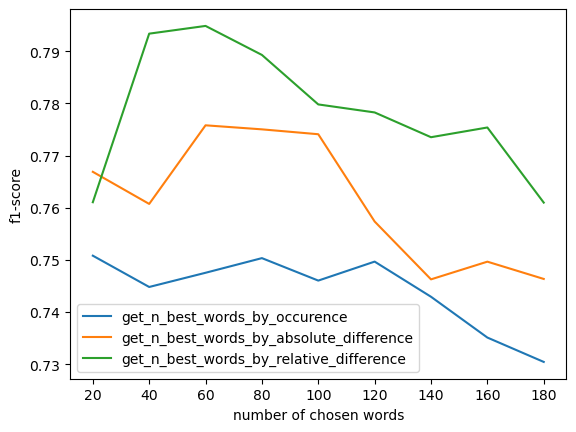

In [105]:
n_list = [20,40,60,80,100,120,140,160,180]
functions_list=[get_n_best_words_by_occurence,get_n_best_words_by_absolute_difference,get_n_best_words_by_relative_difference]
plot_n_values(n_list,functions_list)

## Predictor for test set

In [17]:
with Path(os.path.join(path,"./data/teaching-dataset/sentence_classification_text_test.zip")).open("rb") as file:
    zip_file = ZipFile(file)
    with zip_file.open("input.txt") as f:
        test_sentences = f.read().decode("utf-8").splitlines()

In [18]:
test_predictions = []
for sentence in tqdm.tqdm(test_sentences):
    test_predictions.append(predict(sentence, causal_cues))
Path("predictions.txt").write_text("\n".join(map(str, test_predictions)));

  0%|          | 0/840 [00:00<?, ?it/s]